### Import Modules

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# Text
import nltk, re
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load Data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
df = pd.read_csv('gdrive/My Drive/IBM/Consumer_Complaints.csv', parse_dates = ['Date received', 'Date sent to company'])

Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-10-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",PA,19143,NaN,NaN,Web,2019-10-05,Closed with explanation,Yes,NaN,3396561
1,2019-10-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,334XX,NaN,NaN,Web,2019-10-05,Closed with explanation,Yes,NaN,3396616
2,2019-10-05,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",MS,39401,Servicemember,NaN,Web,2019-10-05,Closed with explanation,Yes,NaN,3396602
3,2019-10-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",MA,01109,NaN,NaN,Web,2019-10-05,Closed with explanation,Yes,NaN,3396599
4,2019-10-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",PA,19135,NaN,NaN,Web,2019-10-05,Closed with explanation,Yes,NaN,3396589


In [4]:
len(df)

1400038

### Plot Each Category by Date

In [5]:
df['Date received'] = df['Date received'].dt.date

In [6]:
group_df = df.groupby(['Date received','Sub-product']).count()['Consumer complaint narrative'].unstack()

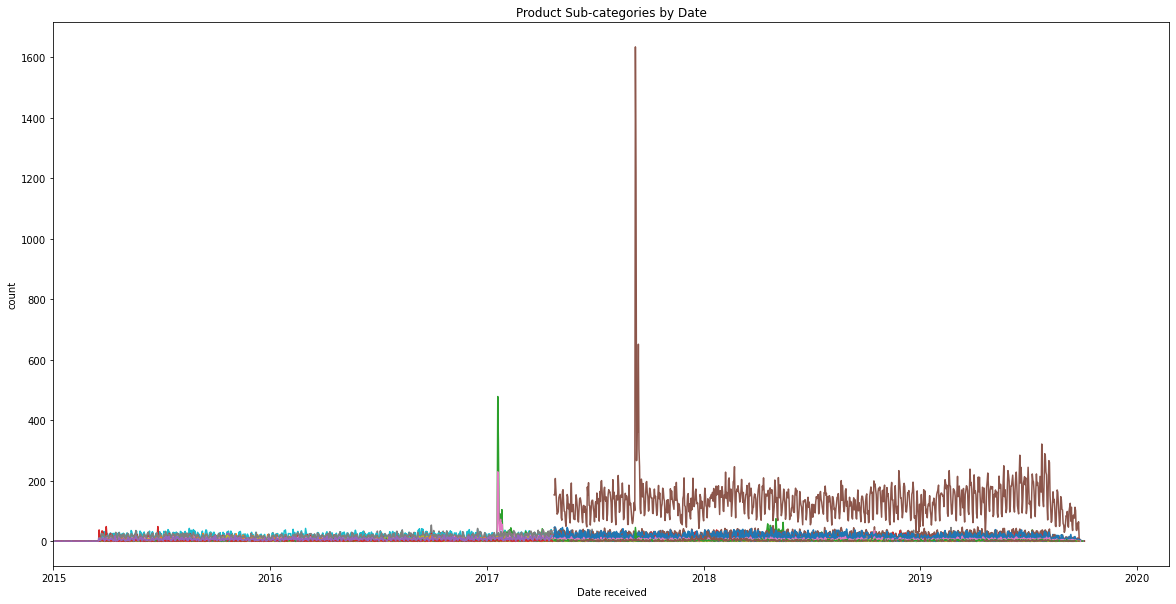

In [7]:
plot = group_df.plot(legend=False, figsize=(20,10))
plot.set_ylabel('count')
plot.set_title('Product Sub-categories by Date')
plot.set_xlim(left=dt.date(2015,1,1));

### Get Product Category List
From the above plot we can see that product categories have been updated, so not all categories in the data are present at the moment. Let's analyze when the first and the last comments were received for each product category.

In [8]:
product_group = df.groupby('Sub-product')
product_group[['Date received']].max().merge(product_group[['Date received']].min(), left_index=True, right_index=True, suffixes=('_max','_min')).sort_values(by=['Date received_max', 'Date received_min'], ascending=False)

,Date received_max,Date received_min
Sub-product,,
Credit reporting,2019-10-05,2017-04-24
Credit card debt,2019-10-04,2017-04-24
Loan,2019-10-04,2017-04-24
I do not know,2019-10-04,2013-07-10
Checking account,2019-10-04,2012-03-01
...,...,...
Traveler’s/Cashier’s checks,2017-04-12,2014-07-23
Transit card,2017-04-08,2014-08-10
Electronic Benefit Transfer / EBT card,2017-04-06,2014-11-06


List of active categories today are as follows:

In [9]:
subproducts = list(df.loc[df['Date received'] > dt.date(2019, 1, 1),'Sub-product'].unique())
len(subproducts)

48

In [10]:
subproducts

['Credit reporting',
 'I do not know',
 'Loan',
 'Checking account',
 'Credit card debt',
 'Other banking product or service',
 'Other debt',
 'Payday loan debt',
 'Medical debt',
 'FHA mortgage',
 'Conventional home mortgage',
 'Other personal consumer report',
 'General-purpose credit card or charge card',
 'Title loan',
 'Installment loan',
 'Auto debt',
 'Lease',
 'Savings account',
 'Store credit card',
 'Federal student loan servicing',
 'Personal line of credit',
 'Private student loan debt',
 'Mobile or digital wallet',
 'VA mortgage',
 'General-purpose prepaid card',
 'Payday loan',
 'Money order',
 'Mortgage debt',
 'Private student loan',
 'Domestic (US) money transfer',
 'Other type of mortgage',
 'Debt settlement',
 'Credit repair services',
 'Payroll card',
 'Virtual currency',
 'CD (Certificate of Deposit)',
 'Home equity loan or line of credit (HELOC)',
 'Pawn loan',
 'Reverse mortgage',
 'International money transfer',
 'Federal student loan debt',
 'Government benefit

Remove 'I do not know' from product category.

In [11]:
subproducts.pop(subproducts.index('I do not know'))

'I do not know'

In [12]:
len(subproducts)

47

Handle null for product category. Look at parent category to see if we can get the omitted product category from there.

In [13]:
df.loc[df['Sub-product'].isnull(), 'Product'].unique()

array(['Credit reporting', 'Credit card', 'Payday loan'], dtype=object)

Since null data in 'Credit card' parent category have two possible categories it can fall into ('General-purpose credit or charge card' and 'Store credit card'), we will exclude these data points.

In [14]:
df.loc[df['Product']=='Credit card', 'Sub-product'].unique()

array([nan], dtype=object)

In [15]:
df.loc[df['Sub-product']=='General-purpose credit card or charge card', 'Product'].unique()

array(['Credit card or prepaid card'], dtype=object)

In [16]:
df.loc[df['Sub-product']=='Store credit card', 'Product'].unique()

array(['Credit card or prepaid card'], dtype=object)

For parent categories 'Credit reporting' and 'Payday loan', we have the exact same categories in our product category list, so we sill assign them accordingly.

In [17]:
df.loc[df['Product']=='Credit reporting', 'Sub-product'] = 'Credit reporting'
df.loc[df['Product']=='Payday loan', 'Sub-product'] = 'Payday loan'

### Get Updated Data
Only include data that fall into active categories.

In [18]:
processed_df = df[[x in subproducts for x in df['Sub-product']]]
processed_df = processed_df[['Sub-product', 'Consumer complaint narrative']]
processed_df.head()

,Sub-product,Consumer complaint narrative
0,Credit reporting,NaN
1,Credit reporting,NaN
2,Credit reporting,NaN
3,Credit reporting,NaN
4,Credit reporting,NaN


Drop data points without narratives.

In [19]:
processed_df.dropna(0, inplace = True)
processed_df.head()

,Sub-product,Consumer complaint narrative
670,General-purpose credit card or charge card,CITI BANK in his response to XXXX asked me idi...
694,Other debt,THIS ACCOUNT IS A RESULT OF IDENTITY THEFT.
700,Other debt,Pro Collect has sent documents that dont match...
718,Medical debt,On XX/XX/2019 I sent PlusFour Inc a certified ...
756,Credit card debt,Client Services is reporting negative informat...


In [20]:
from google.colab import files

# processed_df.to_csv('processed_df.csv', index=False)
# files.download('processed_df.csv')
# processed_df = pd.read_csv('gdrive/My Drive/IBM/processed_df.csv')

### Tokenize and Stem

In [21]:
### NEXT STEP: USE LEMMATIZER INSTEAD OF STEMMER TO IMPROVE THE RESULT

stemmer = PorterStemmer()

def tokenize_and_stem(text):
    lowers = text.lower()
    tokens = [word for sent in nltk.sent_tokenize(lowers) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and not token in stopwords.words('english'):
            filtered_tokens.append(re.sub(r'[^\w\s]','',token))
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [22]:
processed_df['tokenized narrative'] = [tokenize_and_stem(x) for x in processed_df['Consumer complaint narrative']]

In [23]:
processed_df.head(10)

,Sub-product,Consumer complaint narrative,tokenized narrative
670,General-purpose credit card or charge card,CITI BANK in his response to XXXX asked me idi...,"[citi, bank, respons, xxxx, ask, idiot, questi..."
694,Other debt,THIS ACCOUNT IS A RESULT OF IDENTITY THEFT.,"[account, result, ident, theft]"
700,Other debt,Pro Collect has sent documents that dont match...,"[pro, collect, sent, document, dont, match, mo..."
718,Medical debt,On XX/XX/2019 I sent PlusFour Inc a certified ...,"[xxxx2019, sent, plusfour, inc, certifi, lette..."
756,Credit card debt,Client Services is reporting negative informat...,"[client, servic, report, neg, inform, credit, ..."
759,Credit reporting,What they have reported : i was late on a paym...,"[report, late, payment, loan, paid, full, neve..."
767,Other debt,I checked my credit report which shows delinqu...,"[check, credit, report, show, delinqu, coi, co..."
770,Medical debt,I started this journey XX/XX/XXXX of this year...,"[start, journey, xxxxxxxx, year, check, credit..."
810,Medical debt,In XX/XX/XXXX I was approved for 100 % financi...,"[xxxxxxxx, approv, financi, aid, xxxx, xxxx, x..."
829,Credit reporting,ARS ACCOUNT RESOLUTIONS are still reporting in...,"[ar, account, resolut, still, report, inform, ..."


In [25]:
processed_df['stemmed narrative']  = processed_df['tokenized narrative'].apply(lambda x: re.sub('x{2,}', '', ' '.join(x)))

In [26]:
processed_df.head()

,Sub-product,Consumer complaint narrative,tokenized narrative,stemmed narrative
670,General-purpose credit card or charge card,CITI BANK in his response to XXXX asked me idi...,"[citi, bank, respons, xxxx, ask, idiot, questi...",citi bank respons ask idiot question inapplic...
694,Other debt,THIS ACCOUNT IS A RESULT OF IDENTITY THEFT.,"[account, result, ident, theft]",account result ident theft
700,Other debt,Pro Collect has sent documents that dont match...,"[pro, collect, sent, document, dont, match, mo...",pro collect sent document dont match move date...
718,Medical debt,On XX/XX/2019 I sent PlusFour Inc a certified ...,"[xxxx2019, sent, plusfour, inc, certifi, lette...",2019 sent plusfour inc certifi letter via usp ...
756,Credit card debt,Client Services is reporting negative informat...,"[client, servic, report, neg, inform, credit, ...",client servic report neg inform credit report ...


In [27]:
processed_df.drop('tokenized narrative', axis=1, inplace=True)
processed_df.head()

,Sub-product,Consumer complaint narrative,stemmed narrative
670,General-purpose credit card or charge card,CITI BANK in his response to XXXX asked me idi...,citi bank respons ask idiot question inapplic...
694,Other debt,THIS ACCOUNT IS A RESULT OF IDENTITY THEFT.,account result ident theft
700,Other debt,Pro Collect has sent documents that dont match...,pro collect sent document dont match move date...
718,Medical debt,On XX/XX/2019 I sent PlusFour Inc a certified ...,2019 sent plusfour inc certifi letter via usp ...
756,Credit card debt,Client Services is reporting negative informat...,client servic report neg inform credit report ...


In [28]:
from google.colab import files

processed_df.to_csv('stemmed.csv', index = False)
files.download('stemmed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>